# 3 - Modelling - IMDb Dataset
In this noteboook, we will create, evaluate and improve machine learning models to predict spoilers given a review. 

**Dataset**: [IMDb Spoilers Dataset](https://www.kaggle.com/rmisra/imdb-spoiler-dataset).

In [1]:
# import important modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation 

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    plot_confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# text preprocessing modules
from nltk.tokenize import word_tokenize
# from cleantext import clean

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re #regular expression


# from wordcloud import WordCloud, STOPWORDS

# # Download dependency
# for dependency in (
#     "brown",
#     "names",
#     "wordnet",
#     "averaged_perceptron_tagger",
#     "universal_tagset",
#     "stopwords"
# ):
#     nltk.download(dependency)

#nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)

[nltk_data] Downloading package brown to /Users/raj/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to /Users/raj/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/raj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/raj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/raj/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/raj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [2]:
import pathlib

# locate data files
data_dir = pathlib.Path('../data/processed_dataset')
filename = 'processed_sample.csv'

# Read the json files.
data_df = pd.read_csv(data_dir / filename)

In [4]:
data_df.head()

,is_spoiler,review_text,review_summary
0,0,seeing movie duty plea e every serious sci fan...,destined movie
1,0,kept seeing getting compared indiana jones mov...,wish matthew mcconaughey would get struck ligh...
2,0,dark netflix german tv show talk mysterious di...,incredible incredible
3,0,start state clich like movie pretentious film ...,wachowski matrix brother really
4,0,comment may contain spoiler seen came mixed fe...,scary time suffers bad script


# Data Preparation

In [11]:
X = data_df['review_text']
y = data_df['is_spoiler']


# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    stratify=y,
)

In [12]:
# Transform text data 
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)

#transform train data 
X_train_trans = vectorizer.transform(X_train)

#transform test data
X_text_trans = vectorizer.transform(X_test)

In [24]:
# train model
model = MultinomialNB()

# Get cross validated score
scores = cross_val_score(model,
                         X_train_trans,
                         y_train,
                         cv=10,
                         verbose=3,
                         n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished


In [25]:
scores.mean()

0.7355764705882353

<BarContainer object of 10 artists>

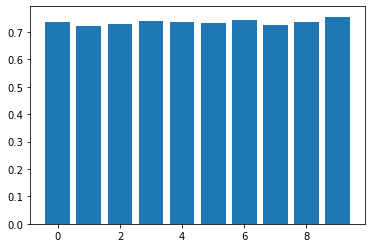

In [27]:
fig, ax = plt.subplots()

ax.bar(x=range(len(scores)), height=scores)

In [32]:
model.fit(X_train_trans, y_train)

# predict on the test data
y_pred = model.predict(X_text_trans)

# check accuracy score
accuracy_score(y_test, y_pred)

0.7456

In [35]:
test = 'Here’s a conundrum: how do you wrap up a 22-movie saga, follow up the most iconic shock blockbuster ending since The Empire Strikes Back, and provide a satisfying ending for some of the most beloved screen heroes of the last decade? If you’re Avengers: Endgame, you do it with stunning ease – the Marvel Cinematic Universe’s latest offering a powerful, emotion, thrilling and playful three-hour epic, stuffed with fan service and jaw-dropping pay-offs. Empire sat down with the films directors, Anthony and Joe Russo, and its writers, Christopher Markus and Stephen McFeely, for some spoiler-heavy conversations, talking the film’s major revelations, twists, deaths, and more – and they delivered all kinds of fascinating insights into one of the biggest movies of all time.'
test

'Here’s a conundrum: how do you wrap up a 22-movie saga, follow up the most iconic shock blockbuster ending since The Empire Strikes Back, and provide a satisfying ending for some of the most beloved screen heroes of the last decade? If you’re Avengers: Endgame, you do it with stunning ease – the Marvel Cinematic Universe’s latest offering a powerful, emotion, thrilling and playful three-hour epic, stuffed with fan service and jaw-dropping pay-offs. Empire sat down with the films directors, Anthony and Joe Russo, and its writers, Christopher Markus and Stephen McFeely, for some spoiler-heavy conversations, talking the film’s major revelations, twists, deaths, and more – and they delivered all kinds of fascinating insights into one of the biggest movies of all time.'

In [54]:
test1 = vectorizer.transform(pd.DataFrame({'review_text': [text_cleaning(test)]}))

prediction = model.predict(test1)
prediction

array([0])

In [55]:
model

MultinomialNB()

In [16]:
stop_words =  stopwords.words('english')

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"ur", " your ", text)
    text = re.sub(r" nd "," and ",text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r" tkts "," tickets ",text)
    text = re.sub(r" c "," can ",text)
    text = re.sub(r" e g ", " eg ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = re.sub(r" u "," you ",text)
    text = text.lower()  # set in lowercase 
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)